# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Options Pricing with Multiple Models
In the previous notebook, you learned how to predict options prices with MLP Regressor having 4 hidden layers. In this notebook, we will create a function which can be used to predict option prices using different models such as MLP Regressor, Lasso, Random Forest, and Decision Trees. Towards the end, we will visually compare the performance of all the models.

The notebook is structured as follows:
1. [Import the Libraries and Data](#get)
2. [Split the Data](#split)
3. [Define Functions](#def)
4. [Compare All the Models](#compare)
5. [Conclusion](#conclusion)

## Import the Libraries
We will import the `pandas`, `numpy`, `matplotlib`, and `warnings` libraries as usual. For all the models we will be using the `sklearn` library.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For data visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn-v0_8-darkgrid')

# For ignoring warnings
import warnings 
warnings.filterwarnings('ignore')

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# For MLP
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# For Lasso
from sklearn.linear_model import Lasso

# For Decision Tree
from sklearn.tree import DecisionTreeRegressor 

# For Random Forest
from sklearn.ensemble import RandomForestRegressor

<a id='get'></a>
## Get the Data
In the previous notebook, we performed feature engineering and created a dataframe `features_data`. This dataframe has been stored in a CSV file named `features_data_options_pricing.csv`. So let us begin by first importing the data.

In [2]:
# Import the data
options_data = pd.read_csv(
    '../data_modules/features_data_options_pricing_2010_2022.csv',  index_col=0)

# Display the first 5 rows
options_data.tail()

,call_price,years_to_expiry,risk_free_rate,volatility,moneyness
2022-09-29,5.00,0.00274,3.98,0.22,-78.29
2022-09-29,4.28,0.00274,3.98,0.22,-83.29
2022-09-29,3.60,0.00274,3.98,0.22,-88.29
2022-09-29,3.10,0.00274,3.98,0.22,-93.29
2022-09-29,2.51,0.00274,3.98,0.22,-98.29


<a id='split'></a>
## Split the Data
Just as we did in the previous notebook, we use the `train_test_split` method to split the dataset into train and test data in a proportion of 80% and 20%, respectively.

In [3]:
# Split train and test data and remove call price since it's not an input feature
X_train, X_test, y_train, y_test = train_test_split(options_data.drop(['call_price'], axis=1),
                                                    options_data['call_price'], test_size=0.2, shuffle=False)

Now let's normalise the data with `StandardScaler`.

In [4]:
# Standardise the scale of all features for X_train and X_test
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

<a id='def'></a>
## Define Functions
We will create two functions, one for setting model parameters and one for plotting the prediction error.

Let's start with the first function and set the model parameters for each model:
1. model1: This is an MLP Regressor with just four hidden layers. It's the same model that we used in the previous notebook. All the parameters are the same as they were in that notebook.
2. model2: This is an MLP Regressor with just one hidden layer, the only parameter that changes here is that we are using one hidden layer instead of four.
3. model3: This is the Lasso model where we are setting the alpha as `1`.
4. model4: This is the Decision Tree Regressor model. The maximum depth of the tree should not be too high as it can result in overfitting, here we have set it to `5`. The minimum number of samples is also set to `5`, this too has been selected arbitrarily.
5. model5: This is a Random Forest Regressor model. We have set the `n_estimator`, or the number of trees, as `20` arbitrarily. When the data pertains to the financial market, a lower `n_estimator` is always better so as to avoid overfitting.

The random state has been set to `42` across all models to get a deterministic output every time we run this code.

The hyperparameters that we've set are more or less close to the standard parameters of the model. This is done solely for the purpose of illustration because the objective of this notebook is to understand the use of different ML models for predicting option prices. You can also carry out cross-validation and find the most suitable hyperparameters or tune the model parameters in accordance with your preferences.

Finally, we will create a function to plot the prediction error. This will be done in the same way as in the previous notebook.

In [5]:
def model(model_name, train_data):

    # MLP multiple hidden layer parameters
    if model_name == 'mlp_multi_layer':
        model1 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100),
                              solver='adam', shuffle=False, batch_size=64, verbose=False,
                              max_iter=20, activation='relu', random_state=42
                              )
        return model1

    # MLP single hidden layer parameters
    elif model_name == 'mlp_single_layer':
        model2 = MLPRegressor(hidden_layer_sizes=(100),
                              solver='adam', shuffle=False, batch_size=64, verbose=False,
                              max_iter=20, activation='relu', random_state=42
                              )
        return model2

    # Lasso parameters
    elif model_name == 'lasso':
        model3 = Lasso(alpha=1.0, random_state=42)
        return model3

    # Decision tree parameters
    elif model_name == 'decision_trees':
        model4 = DecisionTreeRegressor(
            max_depth=5, min_samples_leaf=5, random_state=42)
        return model4

    # Random Forest parameters
    elif model_name == 'random_forest':
        model5 = RandomForestRegressor(n_estimators=20, random_state=42)
        return model5


def plot_results(xtest, ytest, prediction, c='green', plotting='error'):

    # Add columns to the xtest dataframe
    test_dataset = pd.DataFrame(xtest, columns=['time_to_expiry', 'risk_free_rate', 'volatility',
                                                'moneyness'])
    test_dataset['call_price'] = ytest.values
    test_dataset['call_price_predicted'] = prediction
    test_dataset['error'] = abs(
        test_dataset['call_price']-test_dataset['call_price_predicted'])

    if plotting != 'error':
        # Plot the moneyness and error
        plt.scatter(test_dataset.moneyness,
                    test_dataset.error, alpha=0.05, color=c)

    # Fit a line
    model_poly = np.poly1d(np.polyfit(
        test_dataset.moneyness, test_dataset.error, 5))
    polyline = np.linspace(-100, 100, 200)

    # Plot the line
    plt.plot(polyline, model_poly(polyline), color=c,
             linestyle='--', label=model_name)

    # Set the title and labels
    plt.xlabel('Moneyness', fontsize=14)
    plt.ylabel('Absolute Prediction Error', fontsize=14)
    plt.title('Prediction Errors of Call Options', fontsize=16)
    plt.legend(prop={'size': 14})

### Try it Out!
You can try out the function yourself. We have illustrated the use of functions with the Lasso model, you can try out any of the 5 models. All you have to do is change the model name in `model_name` and re-run the cell where we have created the function as well as the cell where we are using the function.

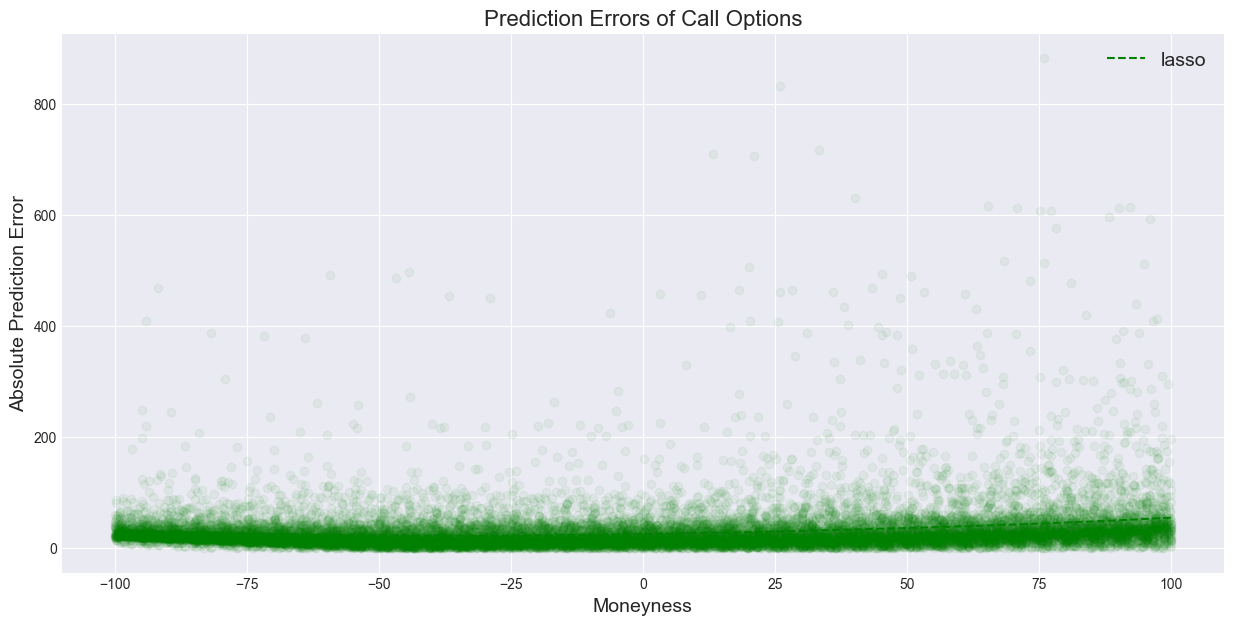

In [6]:
# Set the figure size
figure(figsize=(15, 7))

# Set the model name
model_name = 'lasso'

# Use function to generate model
ml_model = model(model_name, x_train_scaled)

# fit the training data
ml_model.fit(x_train_scaled, y_train)

# predict
pred = ml_model.predict(x_test_scaled)
plot_results(X_test, y_test, pred, plotting='scatter')

<a id='compare'></a>
## Compare All the Models
We will now run a loop to plot the prediction errors of all 5 models. 

Note: The following block of code may take a few minutes to run.

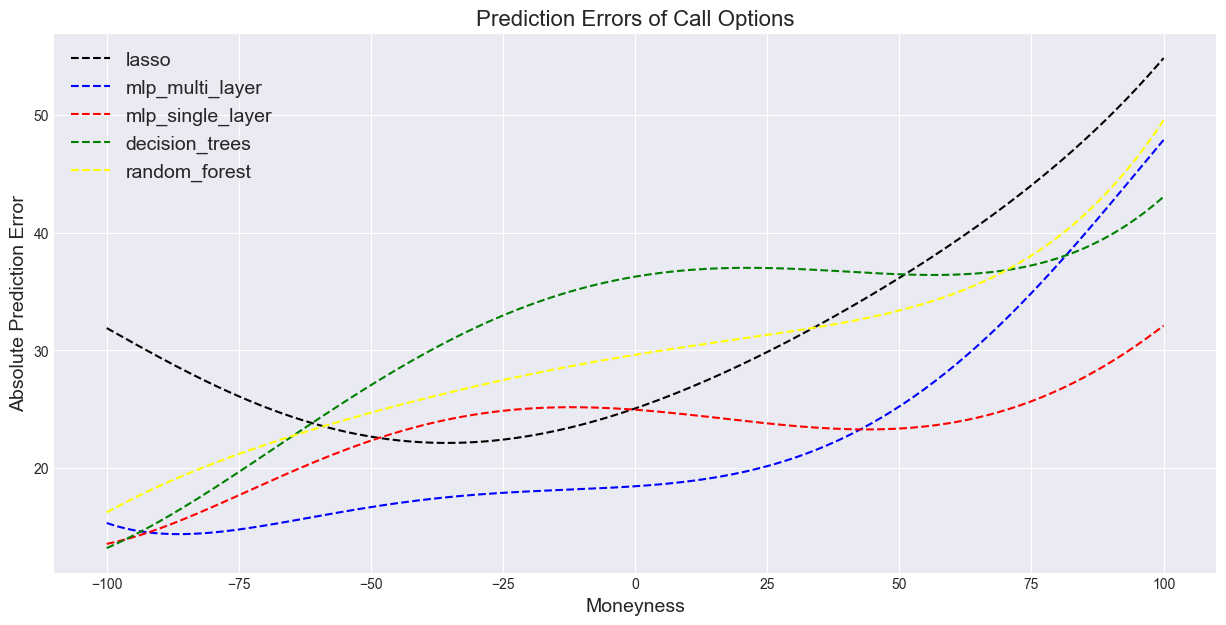

In [7]:
# Set the figure size
figure(figsize=(15, 7))

# List of all the models
all_model_names = ['lasso', 'mlp_multi_layer',
                   'mlp_single_layer', 'decision_trees', 'random_forest']
col = ['black', 'blue', 'red', 'green', 'yellow']

# Loop for plotting prediction error from all models
for (model_name, colour) in zip(all_model_names, col):

    # Use function to generate model
    ml_model = model(model_name, x_train_scaled)

    # fit the training data
    ml_model.fit(x_train_scaled, y_train)

    # predict
    pred = ml_model.predict(x_test_scaled)
    plot_results(X_test, y_test, pred, c=colour)

As you can see, the model with the highest prediction error for in-the-money and out-of-the-money contracts is lasso. On the other hand, the lowest error for in-the-money contracts can be seen in MLP with a single layer. When it comes to at-the-money contracts, the decision tree model has the highest prediction error.

<a id='conclusion'></a>
## Conclusion
With this notebook, you have learned how to predict options prices. You have also learned how to interpret the accuracy of the model based on the absolute prediction error, an even better approach would be to base it on the prediction error in terms of percentage.

Until now we've predicted the call option prices, to improve your understanding, you can try using any model for predicting put option prices. <br><br>